In [1]:
import os
import numpy as np
import pandas as pd
import cvxpy as cp
import osqp
import matplotlib.pyplot as plt
from vector_kernels import *

In [2]:
# tool for pretty plots with mean + std
def lineplotCI(x, y, low, up, c, alp = 0.2):
    plt.plot(x, y, lw = 2, color = c, alpha = 1)
    plt.fill_between(x, low, up, color = c, alpha = alp)

In [3]:
def read_data_mat100(dataset="tr0"):
    folder = "kernel-methods-for-machine-learning-2018-2019"
    features_file = "X" + dataset + "_mat100.csv"
    labels_file = "Y" + dataset + ".csv"
    
    X = pd.read_csv(
        os.path.join(folder, features_file),
        sep=" ",
        header=None
    )
    if "te" in dataset:
        return np.array(X)
    
    elif "tr" in dataset:
        Y = pd.read_csv(
            os.path.join(folder, labels_file),
            sep=",",
            index_col=0,
        )
        return np.array(X), 2 * np.array(Y.iloc[:, 0]) - 1

In [4]:
def compute_predictor(Xtr, Ytr, kernel, lambd):
    m = Xtr.mean(axis=0)
    s = Xtr.std(axis=0)
    Xc = (Xtr - m)/s

    n = len(Xc)

    I = np.eye(n)
    U = (1/n) * np.ones((n, n))
    gram_matrix = kernel(Xc, Xc)
    K = gram_matrix + 1e-9*I
    
    alpha = cp.Variable(n)

    constraints = [
        cp.multiply(Ytr, alpha) >= np.zeros(n),
        cp.multiply(Ytr, alpha) <= np.ones(n) / (2 * lambd * n)
    ]

    objective = cp.Minimize(
        - 2 * (Ytr * alpha)
        + cp.quad_form(alpha, K)
    )

    prob = cp.Problem(objective, constraints)

    result = prob.solve(solver=cp.OSQP, verbose=False)
    
    return lambda x_new: np.sign(alpha.value.dot(kernel(Xc, (x_new - m)/s)))

In [5]:
def cross_validate(X, Y, kernel, lambd, shuffle = True, kfold = 5):
    acc_train, acc_val = np.zeros(kfold), np.zeros(kfold)
    
    # jointly shuffle input datasets X, Y
    n = X.shape[0]
    if shuffle:
        perm = np.random.permutation(n)
        X, Y = X[perm], Y[perm]
    idx = np.arange(n)
    for k in range(kfold):
        # split the datasets
        val_idx = idx[k::kfold]
        train_idx = np.delete(idx, val_idx)
        n_train = len(train_idx)
        n_val = n - n_train
        
        X_train = X[train_idx]
        Y_train = Y[train_idx]
        X_val = X[val_idx]
        Y_val = Y[val_idx]
        
        # fit the predictor
        f = compute_predictor(X_train, Y_train, kernel, lambd)

        Yte_train = f(X_train).reshape(-1)
        Ypred_train = ((Yte_train + 1) / 2).astype(int)

        Yte_val = f(X_val).reshape(-1)
        Ypred_val = ((Yte_val + 1) / 2).astype(int)
        
        Y_train = ((Y_train + 1) / 2).astype(int)
        Y_val = ((Y_val + 1) / 2).astype(int)
        
        # compute metrics
        acc_train[k] = np.mean(Y_train == Ypred_train)
        acc_val[k] = np.mean(Y_val == Ypred_val)
    return acc_train, acc_val

In [6]:
dataset = []
for k in [0, 1, 2]:
    Xtr, Ytr = read_data_mat100("tr" + str(k))
    Xte = read_data_mat100("te" + str(k))
    dataset.append([Xtr, Ytr, Xte])

### Grid search on lambda (on each dataset)

In [8]:
lambd_range = [1e-1, 2e-1, 5e-1, 1., 2., 5, 10]
kfold = 5
acc_train = np.zeros((len(lambd_range), kfold))
acc_val = np.zeros((len(lambd_range), kfold))
for i, lambd in enumerate(lambd_range):
    Xtr, Ytr, _ = dataset[0]
    acc_train[i], acc_val[i] = cross_validate(Xtr, Ytr, gauss(3), lambd, shuffle=True, kfold=kfold)
    print('Lambda: ', lambd)
    print('Train accuracy: ', np.mean(acc_train[i]))
    print('Valid accuracy: ', np.mean(acc_val[i]))
    print('------------')

Lambda:  0.1
Train accuracy:  0.994375
Valid accuracy:  0.5640000000000001
------------
Lambda:  0.2
Train accuracy:  0.9716249999999998
Valid accuracy:  0.5495
------------
Lambda:  0.5
Train accuracy:  0.9571249999999999
Valid accuracy:  0.5525
------------
Lambda:  1.0
Train accuracy:  0.9517499999999999
Valid accuracy:  0.5405
------------
Lambda:  2.0
Train accuracy:  0.94825
Valid accuracy:  0.5294999999999999
------------
Lambda:  5
Train accuracy:  0.9405000000000001
Valid accuracy:  0.5245
------------
Lambda:  10
Train accuracy:  0.93025
Valid accuracy:  0.5265
------------


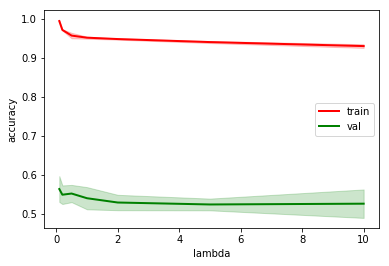

In [9]:
plt.figure()
lineplotCI(lambd_range, acc_train.mean(axis=1), acc_train.mean(axis=1)+acc_train.std(axis=1),
           acc_train.mean(axis=1)-acc_train.std(axis=1), c='r')
lineplotCI(lambd_range, acc_val.mean(axis=1), acc_val.mean(axis=1)+acc_val.std(axis=1),
           acc_val.mean(axis=1)-acc_val.std(axis=1), c='g')
plt.legend(['train', 'val'])
plt.xlabel('lambda')
plt.ylabel('accuracy')
plt.show()

In [8]:
best_lambda = 0.1

### Grid search on sigma for the Gaussian Kernel (on each dataset)

DS 1 avec lambda=0.1

In [9]:
sigma_range = [1e-1, 2e-1, 5e-1, 1., 2., 3, 4, 5, 6]
kfold = 5
acc_train = np.zeros((len(sigma_range), kfold))
acc_val = np.zeros((len(sigma_range), kfold))
for i, sigma in enumerate(sigma_range):
    Xtr, Ytr, _ = dataset[0]
    acc_train[i], acc_val[i] = cross_validate(Xtr, Ytr, gauss(sigma), best_lambda, shuffle=True, kfold=kfold)
    print('Sigma: ', sigma)
    print('Train accuracy: ', np.mean(acc_train[i]))
    print('Valid accuracy: ', np.mean(acc_val[i]))
    print('------------')

Sigma:  0.1
Train accuracy:  1.0
Valid accuracy:  0.5199999999999999
------------
Sigma:  0.2
Train accuracy:  1.0
Valid accuracy:  0.5095000000000001
------------
Sigma:  0.5
Train accuracy:  1.0
Valid accuracy:  0.5605
------------
Sigma:  1.0
Train accuracy:  1.0
Valid accuracy:  0.554
------------
Sigma:  2.0
Train accuracy:  1.0
Valid accuracy:  0.562
------------
Sigma:  3
Train accuracy:  0.9946249999999999
Valid accuracy:  0.5735
------------
Sigma:  4
Train accuracy:  0.9408749999999999
Valid accuracy:  0.552
------------
Sigma:  5
Train accuracy:  0.7665000000000001
Valid accuracy:  0.5365
------------
Sigma:  6
Train accuracy:  0.6355
Valid accuracy:  0.5305
------------


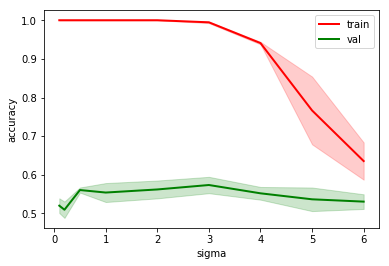

In [10]:
plt.figure()
lineplotCI(sigma_range, acc_train.mean(axis=1), acc_train.mean(axis=1)+acc_train.std(axis=1),
           acc_train.mean(axis=1)-acc_train.std(axis=1), c='r')
lineplotCI(sigma_range, acc_val.mean(axis=1), acc_val.mean(axis=1)+acc_val.std(axis=1),
           acc_val.mean(axis=1)-acc_val.std(axis=1), c='g')
plt.legend(['train', 'val'])
plt.xlabel('sigma')
plt.ylabel('accuracy')
plt.show()

Best lambdas and sigmas for the three datasets with the Gaussian kernel :

In [7]:
best_lambdas = [0.1, 0.5, 0.5]
best_sigmas  = [3, 3, 3]

### Timings

In [15]:
Xtr = np.random.randn(2000, 100)
w = np.random.randn(100)
Ytr = (Xtr.dot(w) > 0)

OSQP :

In [20]:
%%timeit
f = compute_predictor(Xtr, Ytr, gauss(1), 1)

1.18 s ± 82.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


ECOS :

In [18]:
%%timeit
f = compute_predictor(Xtr, Ytr, gauss(1), 1)

1.82 s ± 471 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


SCS : did not finish

In [16]:
%%time
f = compute_predictor(Xtr, Ytr, gauss(1), 1)

CPU times: user 9.56 s, sys: 323 ms, total: 9.88 s
Wall time: 8.24 s


In [17]:
%%time
print(np.mean(Ytr == f(Xtr)))

0.4895
CPU times: user 140 ms, sys: 47.8 ms, total: 188 ms
Wall time: 125 ms


### Make the final predictions

In [18]:
Ypred = []
lambd = 0.

for k in [0, 1, 2]:
    print("\nDATASET {}\n".format(k))

    Xtr, Ytr, Xte = dataset[k]
    
    if k==0:
        lambd = .2
    elif k==1:
        lambd = 1.
    elif k==2:
        lambd = .2
    
    f = compute_predictor(Xtr, Ytr, gauss(best_sigmas[k]), best_lambdas[k])
    print(np.mean(Ytr == f(Xtr)))
    Yte = f(Xte)
    
    Ypred.extend(list(((Yte + 1) / 2).astype(int)))
    
Ypred = pd.Series(
    index=np.arange(len(Ypred)),
    data=Ypred
)
Ypred.index.name = "Id"
Ypred.name = "Bound"
Ypred.to_csv("Ypred.csv", header=True)


DATASET 0

0.9905

DATASET 1

1.0

DATASET 2

0.9945
